In [1]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os,random, math, psutil, pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.impute import SimpleImputer

import json

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import gc

pd.set_option('max_columns', 100)

In [2]:
train = pd.read_pickle('../data/interim/train.pkl')
test = pd.read_pickle('../data/interim/test.pkl')
meter_dict = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

# 1. Features selection

In [3]:
cols_to_drop = ['sea_level_pressure', 'wind_direction']
train = train.drop(cols_to_drop, axis=1)

# 2. Imputing

In [4]:
# check columns having missing values
train.columns[train.count()<len(train)]

Index(['year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'wind_speed'],
      dtype='object')

In [5]:
def impute(train):
    # global train
    # list columns with missing values
    cols_missing = list(train.columns[train.count()<len(train)])
    
    print('Columns that have missing values:', cols_missing)
    
    # use linear interpolate forward
    train['air_temperature'] = train['air_temperature'].interpolate(method='linear', limit_direction='forward', axis=0)
    train['air_temperature'] = train['air_temperature'].interpolate(method='pad', axis=0)

    # check
    if train.air_temperature.isnull().sum() == 0:
        print('The air_temperature is fully filled now.')
    
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    train[cols_missing] = imp_mean.fit_transform(train[cols_missing])
    if train.isnull().sum().sum() == 0:
        print('Successfully imputed by SimpleImputer!')

In [6]:
%%time
impute(train)

Columns that have missing values: ['year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'wind_speed']
The air_temperature is fully filled now.
Successfully imputed by SimpleImputer!
Wall time: 31.6 s


## 3. Feature engineering

In [7]:
def feture_engineering(train):

    train['hour'] = train['timestamp'].dt.hour.astype(np.int8)
    # train['dayofweek'] = train['timestamp'].dt.dayofweek.astype(np.int8)
    # train['dayofmonth'] = train['timestamp'].dt.day.astype(np.int8)
    train['dayofyear'] = train['timestamp'].dt.dayofyear.astype(np.int16)
    #train['weekofmonth'] = train['timestamp'].dt.day % 7
    train['weekofyear'] = train['timestamp'].dt.weekofyear.astype(np.int8)
    train['month'] = train['timestamp'].dt.month.astype(np.int8)

    # convert to beaufort_scale
    beaufort = [(0, 0, 0.3), (1, 0.3, 1.6), (2, 1.6, 3.4), (3, 3.4, 5.5), (4, 5.5, 8), (5, 8, 10.8), (6, 10.8, 13.9), 
              (7, 13.9, 17.2), (8, 17.2, 20.8), (9, 20.8, 24.5), (10, 24.5, 28.5), (11, 28.5, 33), (12, 33, 200)]
    for item in beaufort:
        train.loc[(train['wind_speed']>=item[1]) & (train['wind_speed']<item[2]), 'beaufort_scale'] = item[0]    

    # lgb has its own way of treating categorical feature and it is better to do it that way
    # train = pd.get_dummies(train, prefix_sep="_")   

In [8]:
%%time
feture_engineering(train)
train.to_pickle('../data/processed/train.pkl')

Wall time: 14.8 s


# 4. Make X and y

In [9]:
train = pd.read_pickle('../data/processed/train.pkl')

train = train.set_index('timestamp')

# cols = ['hour', 'dayofyear', 'weekofyear', 'month']
# train[cols] = train[cols].astype('category')

def make_X_y(train):    
    X = train.drop(['meter_reading'], axis=1)
    y = np.log1p(train['meter_reading'])
    return X, y
X, y = make_X_y(train)

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20216100 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 17 columns):
 #   Column             Dtype   
---  ------             -----   
 0   building_id        int16   
 1   meter              int8    
 2   site_id            int8    
 3   primary_use        category
 4   square_feet        int32   
 5   year_built         float64 
 6   floor_count        float64 
 7   air_temperature    float64 
 8   cloud_coverage     float64 
 9   dew_temperature    float64 
 10  precip_depth_1_hr  float64 
 11  wind_speed         float64 
 12  hour               int8    
 13  dayofyear          int16   
 14  weekofyear         int8    
 15  month              int8    
 16  beaufort_scale     float64 
dtypes: category(1), float64(8), int16(2), int32(1), int8(5)
memory usage: 1.6 GB


In [11]:
y

timestamp
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
2016-01-01 00:00:00    0.000000
                         ...   
2016-12-31 23:00:00    2.277267
2016-12-31 23:00:00    1.762159
2016-12-31 23:00:00    0.000000
2016-12-31 23:00:00    5.078761
2016-12-31 23:00:00    1.348073
Name: meter_reading, Length: 20216100, dtype: float32

# 5. Light gradient boosting

### 5.1 KFold without shuffling

In [12]:
%%time
models = []

kf = KFold(n_splits=5, shuffle=False)

for train_index, test_index in kf.split(X):
    
    # split train and test set
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

    num_train, num_feature = X_train.shape

    # create dataset for lightgbm
    # set free_raw_data=False to reuse data
    lgb_train = lgb.Dataset(X_train, y_train, weight=None, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, weight=None, free_raw_data=False)

    # specify your configurations as a dict
    params = {
              "objective": "regression",
              "boosting": "gbdt",
              "num_leaves": 1280,
              "learning_rate": 0.1,
              "feature_fraction": 1.0,
              "metric": "rmse"}

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=70,
                      valid_sets=lgb_eval,  # eval train data
                      categorical_feature=['primary_use'], #['hour', 'dayofyear', 'weekofyear', 'month']
                      verbose_eval=25, 
                      early_stopping_rounds=50)
    
    models.append(model)

Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.07366
[50]	valid_0's rmse: 0.976634
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 0.958457
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.05202
[50]	valid_0's rmse: 0.980772
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 0.970041
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.02614
[50]	valid_0's rmse: 0.953845
Did not meet early stopping. Best iteration is:
[69]	valid_0's rmse: 0.945196
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.10768
[50]	valid_0's rmse: 1.06085
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 1.05482
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.26772
[50]	valid_0's rmse: 1.24334
Did not meet early stopping. Best iteration is:
[68]	valid_0's rmse: 1.22945
Wall time: 12m

In [15]:
kf = KFold(n_splits=5, shuffle=False)
scores = []
i = 0
for train_index, test_index in kf.split(X):
          
    X_test = X.iloc[test_index]    
    y_test = y.iloc[test_index]
    
    y_pred = models[i].predict(X_test)
    scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    i += 1

0.958
0.97
0.945
1.055
1.229
average: 1.032


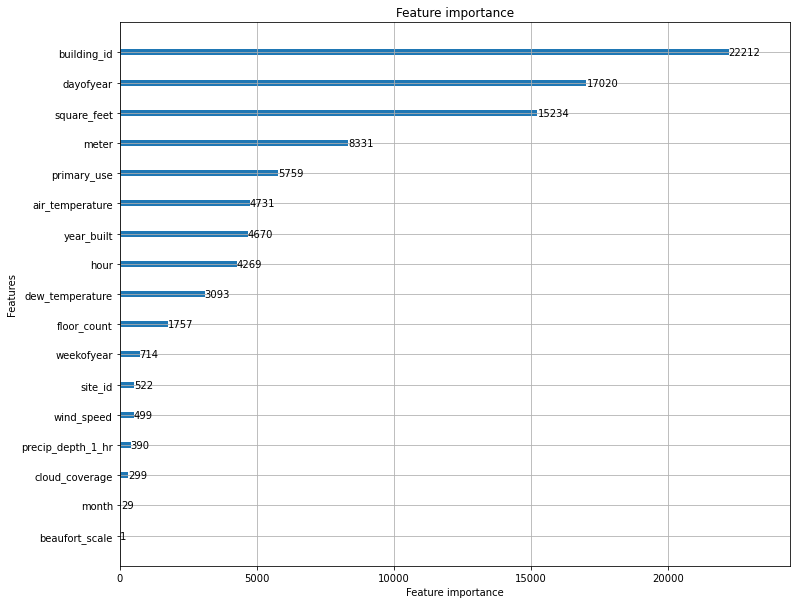

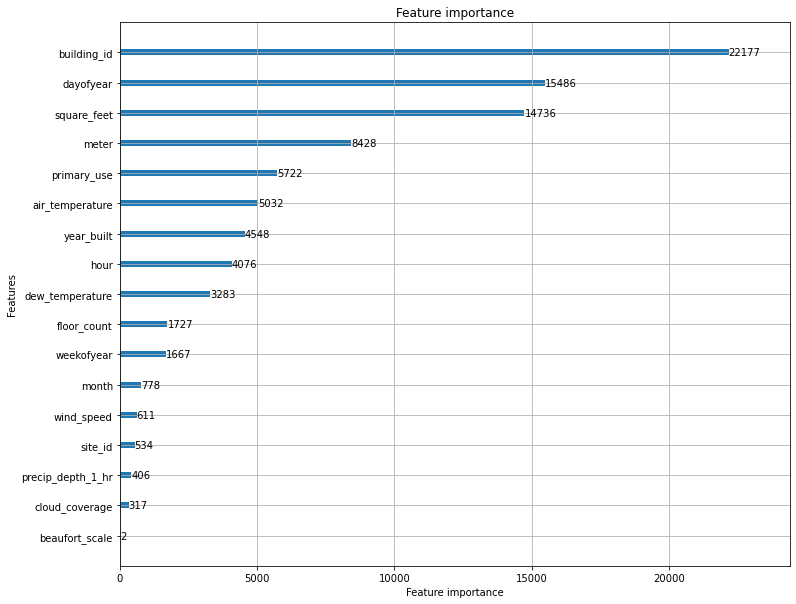

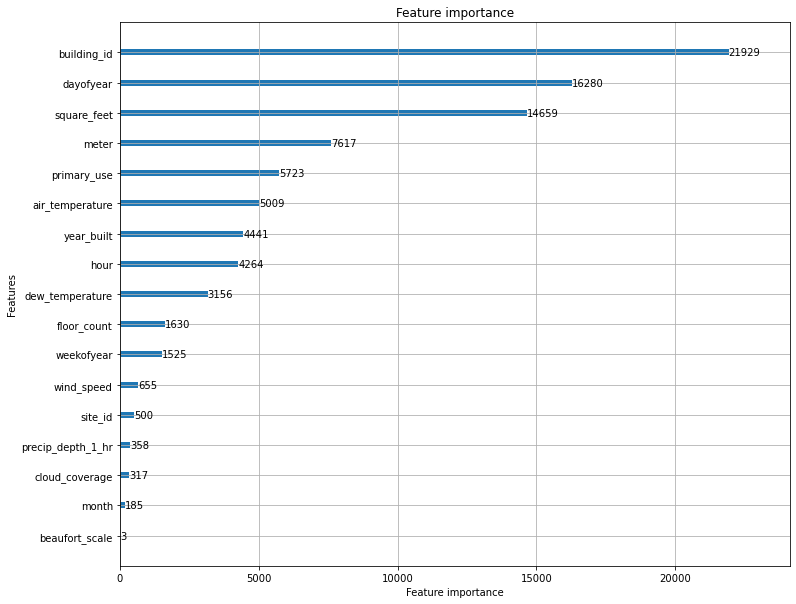

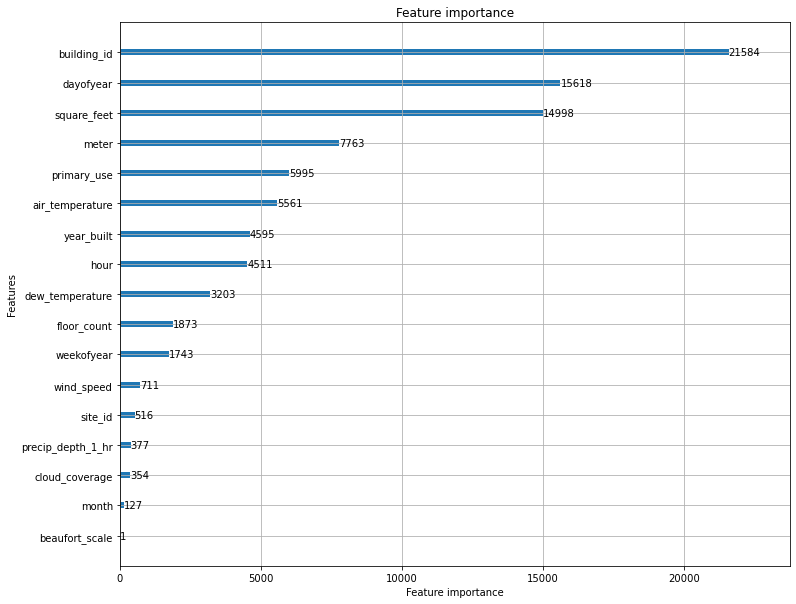

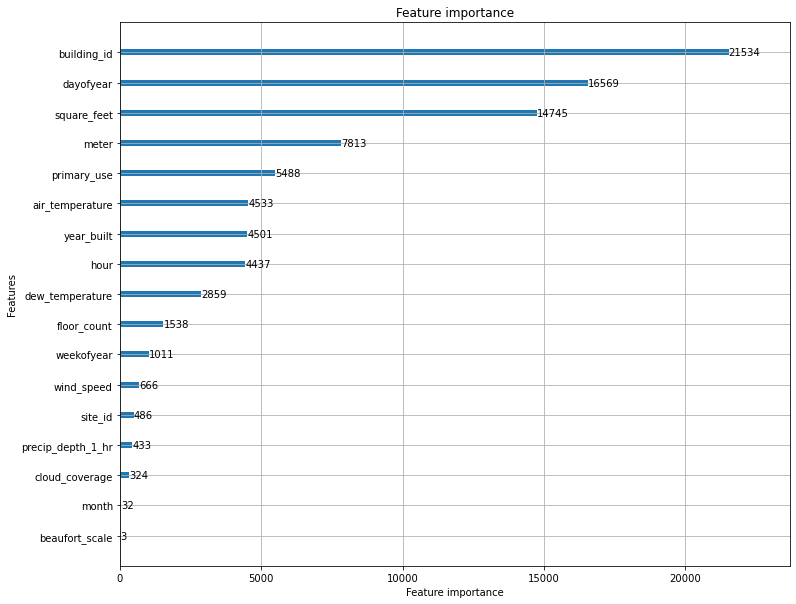

In [16]:
def print_results(scores):
    [print(i) for i in (np.round(scores, 3))]
    avg = np.round(np.mean(scores), 3)
    print(f'average: {avg}')

def plot_importances(models):
    for model in models:
        fig, axes = plt.subplots(figsize=(12, 10))
        lgb.plot_importance(model, ax=axes)
        plt.show()

print_results(scores)
plot_importances(models)

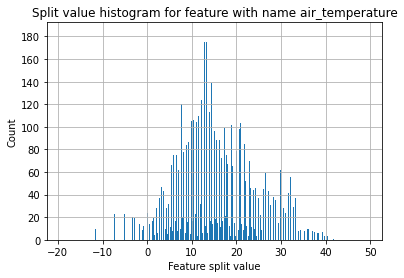

In [17]:
lgb.plot_split_value_histogram(models[0], 'air_temperature')

### 5.2 TimeSeriesSplit
Its cross validation behavious is illustrated below.

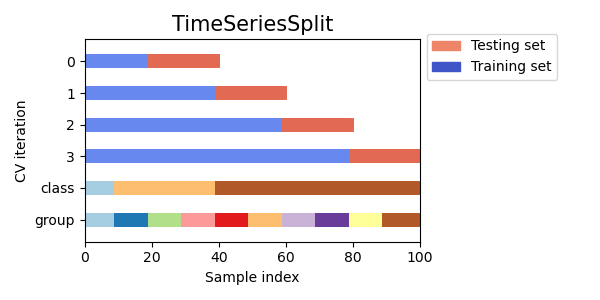

In [18]:
%%time
models = []

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    
    # split train and test set
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    num_train, num_feature = X_train.shape

    # create dataset for lightgbm
    # set free_raw_data=False to reuse data
    lgb_train = lgb.Dataset(X_train, y_train, weight=None, free_raw_data=False)
    lgb_eval = lgb.Dataset(X_test, y_test, weight=None, free_raw_data=False)

    # specify your configurations as a dict
    params = {
              "objective": "regression",
              "boosting": "gbdt",
              "num_leaves": 1280,
              "learning_rate": 0.1,
              "feature_fraction": 0.85,
              "reg_lambda": 2,
              "metric": "rmse"}

    model = lgb.train(params,
                      lgb_train,
                      num_boost_round=70,
                      valid_sets=lgb_eval,  # eval training data
                      categorical_feature="auto",
                      verbose_eval=25, 
                      early_stopping_rounds=50)
    
    models.append(model)

Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.01765
[50]	valid_0's rmse: 0.968602
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 0.961065
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.39324
[50]	valid_0's rmse: 1.38605
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 1.38123
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.74163
[50]	valid_0's rmse: 1.83082
Early stopping, best iteration is:
[13]	valid_0's rmse: 1.67572
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.17398
[50]	valid_0's rmse: 1.14457
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 1.13808
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 1.05698
[50]	valid_0's rmse: 0.969778
Did not meet early stopping. Best iteration is:
[70]	valid_0's rmse: 0.95154
Wall time: 6min 43s


0.958
0.97
0.945
1.055
1.229
average: 1.032


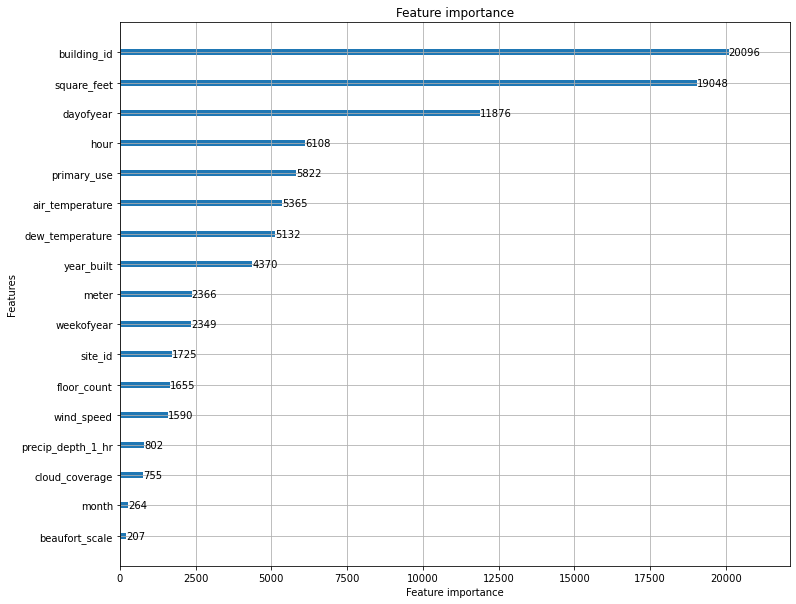

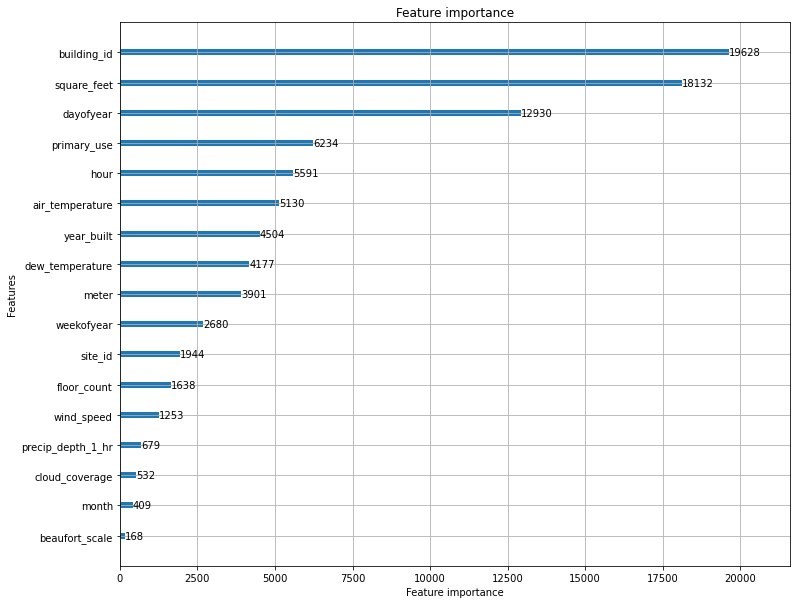

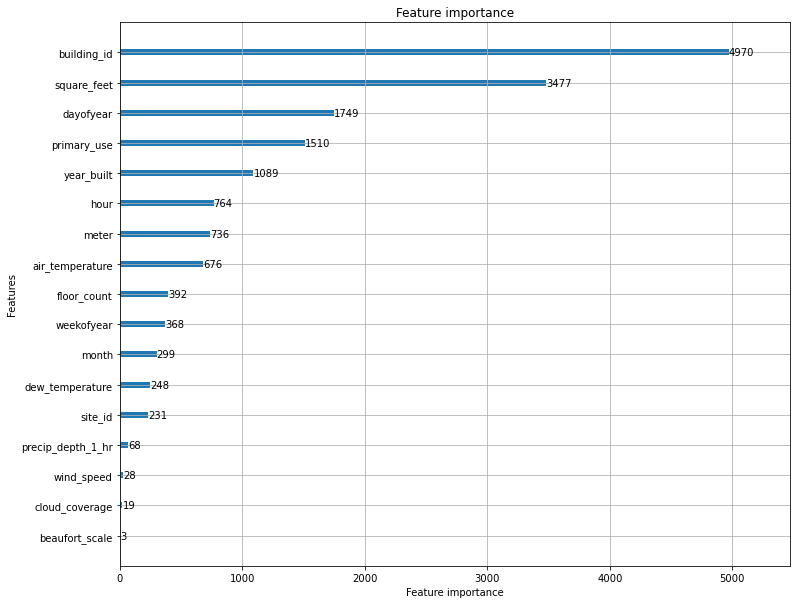

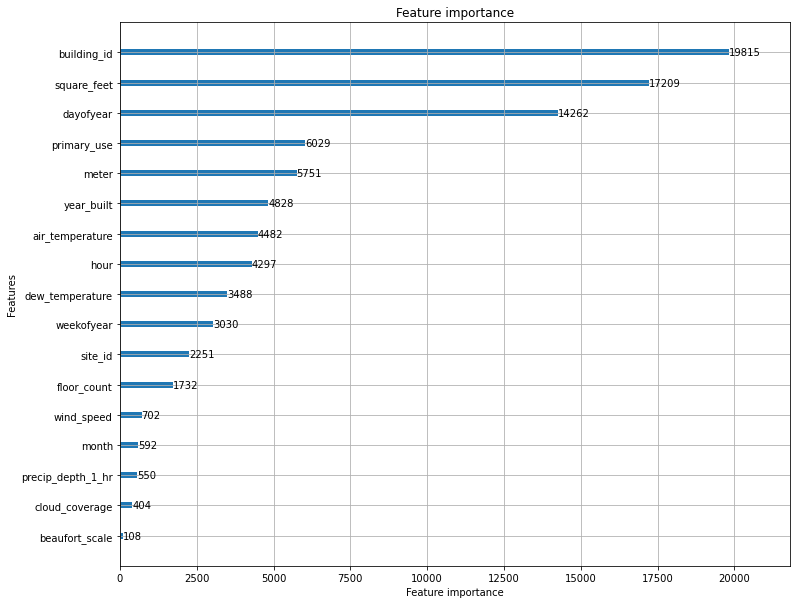

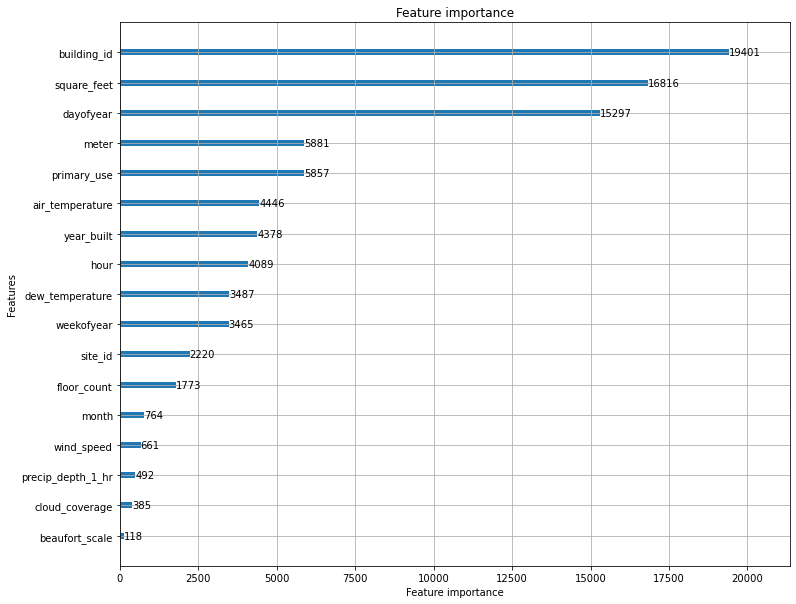

In [19]:
print_results(scores)
plot_importances(models)